# 03 - AF Phenotype Discovery

## Clustering Analysis to Identify Distinct Patient Subtypes

### Objective

Use unsupervised clustering to discover **AF phenotypes** - distinct patient subtypes with different episode patterns, burden trajectories, and potentially different clinical outcomes.

### Methodology

1. **Features**: 118 patient-level features from ILR data
2. **Preprocessing**: Standardization, handle missing values
3. **Clustering Comparison**: K-means, GMM, Spectral, Hierarchical, HDBSCAN (k=3-6)
4. **Filtering**: Min cluster size >= 10, valid points >= 80%
5. **Final Clustering**: Selected based on Silhouette score
6. **Characterization**: Profile each phenotype
7. **Trajectory Visualization**: 365-day ILR profiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from scipy.cluster.hierarchy import dendrogram, linkage

from src.preprocessing import AFDataLoader, EpisodeCleaner, TimeAligner

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
%matplotlib inline

# Colors for phenotypes (enough for up to 6 clusters)
PHENOTYPE_COLORS = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']
RANDOM_STATE = 42

---
## 1. Load Features

In [2]:
# Load features
features_df = pd.read_csv('../output/features_curated.csv')

print("=" * 50)
print("FEATURE DATA")
print("=" * 50)
print(f"  Patients: {len(features_df)}")
print(f"  Features: {len(features_df.columns) - 1}")  # Exclude ID

FEATURE DATA
  Patients: 246
  Features: 14


In [3]:
# Prepare feature matrix
id_col = 'ID'
feature_cols = [c for c in features_df.columns 
                if c != id_col and features_df[c].dtype in ['float64', 'int64', 'float32', 'int32']]

# Remove high-missing features
missing_pct = features_df[feature_cols].isna().mean()
valid_features = missing_pct[missing_pct < 0.2].index.tolist()
print(f"Features with <20% missing: {len(valid_features)}")

# Prepare matrix
X = features_df[valid_features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
for col in X.columns:
    median_val = X[col].median()
    if pd.isna(median_val):
        median_val = 0
    X[col] = X[col].fillna(median_val)

# Clip extreme values
for col in X.columns:
    q99 = X[col].quantile(0.99)
    q01 = X[col].quantile(0.01)
    X[col] = X[col].clip(lower=q01, upper=q99)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

print(f"Feature matrix shape: {X_scaled.shape}")

Features with <20% missing: 14
Feature matrix shape: (246, 14)


---
## 2. Clustering Method Comparison

Compare different clustering algorithms:
1. **K-Means** (current approach)
2. **Gaussian Mixture Models** (probabilistic)
3. **Spectral Clustering** (non-convex clusters)
4. **Agglomerative Hierarchical** (dendrogram)
5. **HDBSCAN** (density-based)

### Understanding Clustering Quality Metrics

When comparing clustering methods, we use three complementary metrics. No single metric is perfect, so we consider them together:

| Metric | Direction | Range | What it measures                                                                                                                                                                              |
|--------|-----------|-------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Silhouette Score** | ↑ Higher = Better | -1 to 1 | How well-separated clusters are.|
| **Calinski-Harabasz Index** | ↑ Higher = Better | 0 to ∞ | Ratio of between-cluster to within-cluster variance. Higher values mean more distinct, compact clusters.                                                                                      |
| **Davies-Bouldin Index** | ↓ Lower = Better | 0 to ∞ | Average similarity between clusters. Lower values (closer to 0) indicate better separation.                                                                                                   |

**Practical guidance for choosing a method:**
1. **Prioritize clinical interpretability** - Can you describe each cluster meaningfully?
2. **Check cluster balance** - Avoid methods with very small clusters (<10 patients)
3. **Consider stability** - K-Means and Hierarchical are generally stable and reproducible
4. **Use domain knowledge** - AF phenotyping literature typically finds 3-5 distinct patterns

A Silhouette score of 0.15-0.35 are common in clinical literature. For synthetic datasets 0.25 are acceptable, >0.5 are good. Negative values indicate overlapping clusters.

In [4]:
# Store results
clustering_results = {}

# Test k values from 3 to 6 for all methods
K_RANGE = [3, 4, 5, 6]

# 1. K-Means for each k
print("Running K-Means...")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    clustering_results[f'K-Means (k={k})'] = kmeans.fit_predict(X_scaled)
    print(f"  k={k} done")

# 2. Gaussian Mixture Models for each k
print("Running GMM...")
for k in K_RANGE:
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE, n_init=5)
    clustering_results[f'GMM (k={k})'] = gmm.fit_predict(X_scaled)
    print(f"  k={k} done")

# 3. Spectral Clustering for each k
print("Running Spectral Clustering...")
for k in K_RANGE:
    spectral = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, affinity='rbf')
    clustering_results[f'Spectral (k={k})'] = spectral.fit_predict(X_scaled)
    print(f"  k={k} done")

# 4. Agglomerative Hierarchical for each k
print("Running Hierarchical Clustering...")
for k in K_RANGE:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clustering_results[f'Hierarchical (k={k})'] = hierarchical.fit_predict(X_scaled)
    print(f"  k={k} done")

# 5. HDBSCAN (automatic k detection)
print("Running HDBSCAN...")
hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
hdbscan_labels = hdb.fit_predict(X_scaled)
n_clusters_hdb = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = (hdbscan_labels == -1).sum()
clustering_results[f'HDBSCAN (k={n_clusters_hdb})'] = hdbscan_labels
print(f"  Found k={n_clusters_hdb} clusters, {n_noise} noise points")

print(f"\nTotal experiments: {len(clustering_results)}")

Running K-Means...
  k=3 done
  k=4 done
  k=5 done
  k=6 done
Running GMM...
  k=3 done
  k=4 done
  k=5 done
  k=6 done
Running Spectral Clustering...
  k=3 done
  k=4 done
  k=5 done
  k=6 done
Running Hierarchical Clustering...
  k=3 done
  k=4 done
  k=5 done
  k=6 done
Running HDBSCAN...
  Found k=2 clusters, 211 noise points

Total experiments: 17


In [5]:
# Filtering thresholds
MIN_CLUSTER_SIZE = 10  # Clusters with fewer than 10 patients are excluded
MIN_VALID_POINTS_PCT = 0.80  # Methods must have at least 80% valid (non-noise) points

# Calculate metrics for each method
metrics_results = []
n_total = len(X_scaled)

for method, labels in clustering_results.items():
    # Filter out noise points for HDBSCAN
    valid_mask = labels >= 0
    valid_points = valid_mask.sum()
    valid_pct = valid_points / n_total
    
    if valid_points < 10:
        continue
    
    n_clusters = len(set(labels[valid_mask]))
    
    # Calculate metrics (only on non-noise points)
    X_valid = X_scaled[valid_mask]
    labels_valid = labels[valid_mask]
    
    if n_clusters > 1:
        silhouette = silhouette_score(X_valid, labels_valid)
        calinski = calinski_harabasz_score(X_valid, labels_valid)
        davies = davies_bouldin_score(X_valid, labels_valid)
    else:
        silhouette = calinski = davies = np.nan
    
    # Cluster size distribution
    unique, counts = np.unique(labels_valid, return_counts=True)
    size_std = np.std(counts)
    min_size = np.min(counts)
    
    # Check validity criteria
    meets_min_size = min_size >= MIN_CLUSTER_SIZE
    meets_valid_pct = valid_pct >= MIN_VALID_POINTS_PCT
    is_valid = meets_min_size and meets_valid_pct
    
    metrics_results.append({
        'Method': method,
        'N Clusters': n_clusters,
        'Silhouette ↑': silhouette,
        'Calinski-Harabasz ↑': calinski,
        'Davies-Bouldin ↓': davies,
        'Min Cluster Size': min_size,
        'Valid Points %': f'{valid_pct*100:.0f}%',
        'Valid': '✓' if is_valid else '✗'
    })

metrics_df = pd.DataFrame(metrics_results)

# Filter to only show valid methods
valid_metrics_df = metrics_df[metrics_df['Valid'] == '✓'].copy()
invalid_metrics_df = metrics_df[metrics_df['Valid'] == '✗'].copy()

# Sort valid methods by Silhouette score (higher is better)
valid_metrics_df = valid_metrics_df.sort_values('Silhouette ↑', ascending=False)

print("Clustering Quality Metrics")
print("=" * 100)
print(f"Filters: min cluster size >= {MIN_CLUSTER_SIZE}, valid points >= {MIN_VALID_POINTS_PCT*100:.0f}%")
print("↑ = higher is better, ↓ = lower is better")
print()
display(valid_metrics_df.round(3))

if len(invalid_metrics_df) > 0:
    print(f"\n⚠ {len(invalid_metrics_df)} methods excluded:")
    for _, row in invalid_metrics_df.iterrows():
        print(f"   - {row['Method']}: min cluster = {row['Min Cluster Size']:.0f}, valid = {row['Valid Points %']}")

Clustering Quality Metrics
Filters: min cluster size >= 10, valid points >= 80%
↑ = higher is better, ↓ = lower is better



,Method,N Clusters,Silhouette ↑,Calinski-Harabasz ↑,Davies-Bouldin ↓,Min Cluster Size,Valid Points %,Valid
1,K-Means (k=4),4,0.247,72.724,1.326,22,100%,✓
0,K-Means (k=3),3,0.245,72.352,1.368,23,100%,✓
12,Hierarchical (k=3),3,0.235,67.672,1.325,22,100%,✓
13,Hierarchical (k=4),4,0.235,66.059,1.321,22,100%,✓
4,GMM (k=3),3,0.109,44.661,2.129,41,100%,✓
7,GMM (k=6),6,0.067,39.906,2.677,11,100%,✓



⚠ 11 methods excluded:
   - K-Means (k=5): min cluster = 6, valid = 100%
   - K-Means (k=6): min cluster = 4, valid = 100%
   - GMM (k=4): min cluster = 7, valid = 100%
   - GMM (k=5): min cluster = 4, valid = 100%
   - Spectral (k=3): min cluster = 4, valid = 100%
   - Spectral (k=4): min cluster = 1, valid = 100%
   - Spectral (k=5): min cluster = 1, valid = 100%
   - Spectral (k=6): min cluster = 1, valid = 100%
   - Hierarchical (k=5): min cluster = 4, valid = 100%
   - Hierarchical (k=6): min cluster = 4, valid = 100%
   - HDBSCAN (k=2): min cluster = 17, valid = 14%


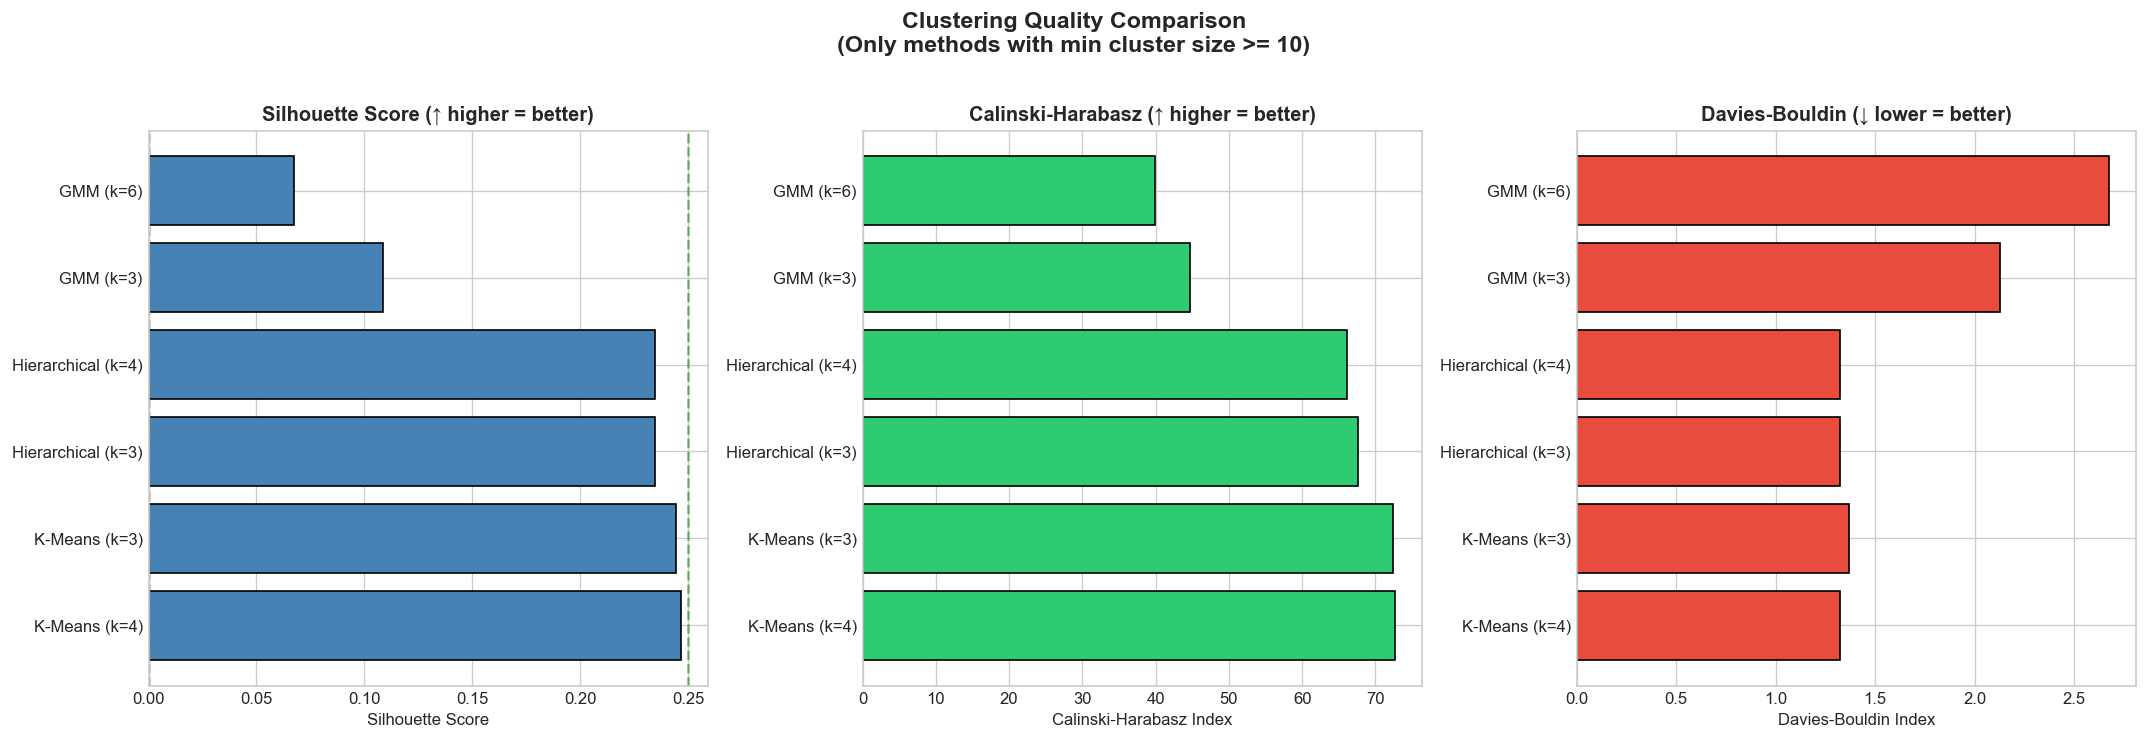

In [6]:
# Visualize metrics comparison (only valid methods)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = valid_metrics_df['Method'].tolist()
x = range(len(methods))

# Silhouette (higher = better)
axes[0].barh(x, valid_metrics_df['Silhouette ↑'], color='steelblue', edgecolor='black')
axes[0].set_yticks(x)
axes[0].set_yticklabels(methods)
axes[0].set_xlabel('Silhouette Score')
axes[0].set_title('Silhouette Score (↑ higher = better)', fontweight='bold')
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(0.25, color='green', linestyle='--', alpha=0.5, label='Good threshold')

# Calinski-Harabasz (higher = better)
axes[1].barh(x, valid_metrics_df['Calinski-Harabasz ↑'], color='#2ecc71', edgecolor='black')
axes[1].set_yticks(x)
axes[1].set_yticklabels(methods)
axes[1].set_xlabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz (↑ higher = better)', fontweight='bold')

# Davies-Bouldin (lower = better)
axes[2].barh(x, valid_metrics_df['Davies-Bouldin ↓'], color='#e74c3c', edgecolor='black')
axes[2].set_yticks(x)
axes[2].set_yticklabels(methods)
axes[2].set_xlabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin (↓ lower = better)', fontweight='bold')

plt.suptitle(f'Clustering Quality Comparison\n(Only methods with min cluster size >= {MIN_CLUSTER_SIZE})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../output/figures/clustering_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

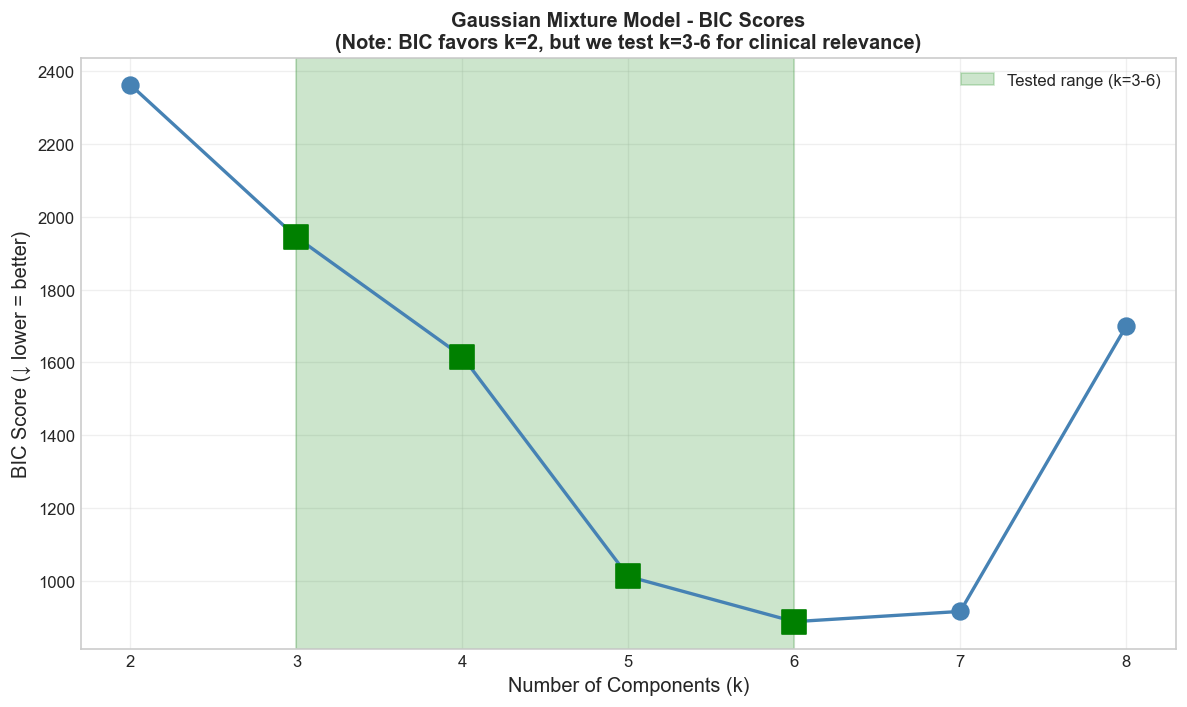

In [7]:
# GMM BIC scores for reference
fig, ax = plt.subplots(figsize=(10, 6))

bic_scores = []
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE, n_init=5)
    gmm.fit(X_scaled)
    bic_scores.append((k, gmm.bic(X_scaled)))

ks = [x[0] for x in bic_scores]
bics = [x[1] for x in bic_scores]

ax.plot(ks, bics, 'o-', linewidth=2, markersize=10, color='steelblue')

# Highlight our tested range (k=3-6)
for k in K_RANGE:
    idx = k - 2  # offset since we start at k=2
    ax.scatter([k], [bics[idx]], color='green', s=200, zorder=5, marker='s')

ax.axvspan(3, 6, alpha=0.2, color='green', label='Tested range (k=3-6)')
ax.set_xlabel('Number of Components (k)', fontsize=12)
ax.set_ylabel('BIC Score (↓ lower = better)', fontsize=12)
ax.set_title('Gaussian Mixture Model - BIC Scores\n(Note: BIC favors k=2, but we test k=3-6 for clinical relevance)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(ks)

plt.tight_layout()
plt.savefig('../output/figures/gmm_bic_selection.png', dpi=150, bbox_inches='tight')
plt.show()

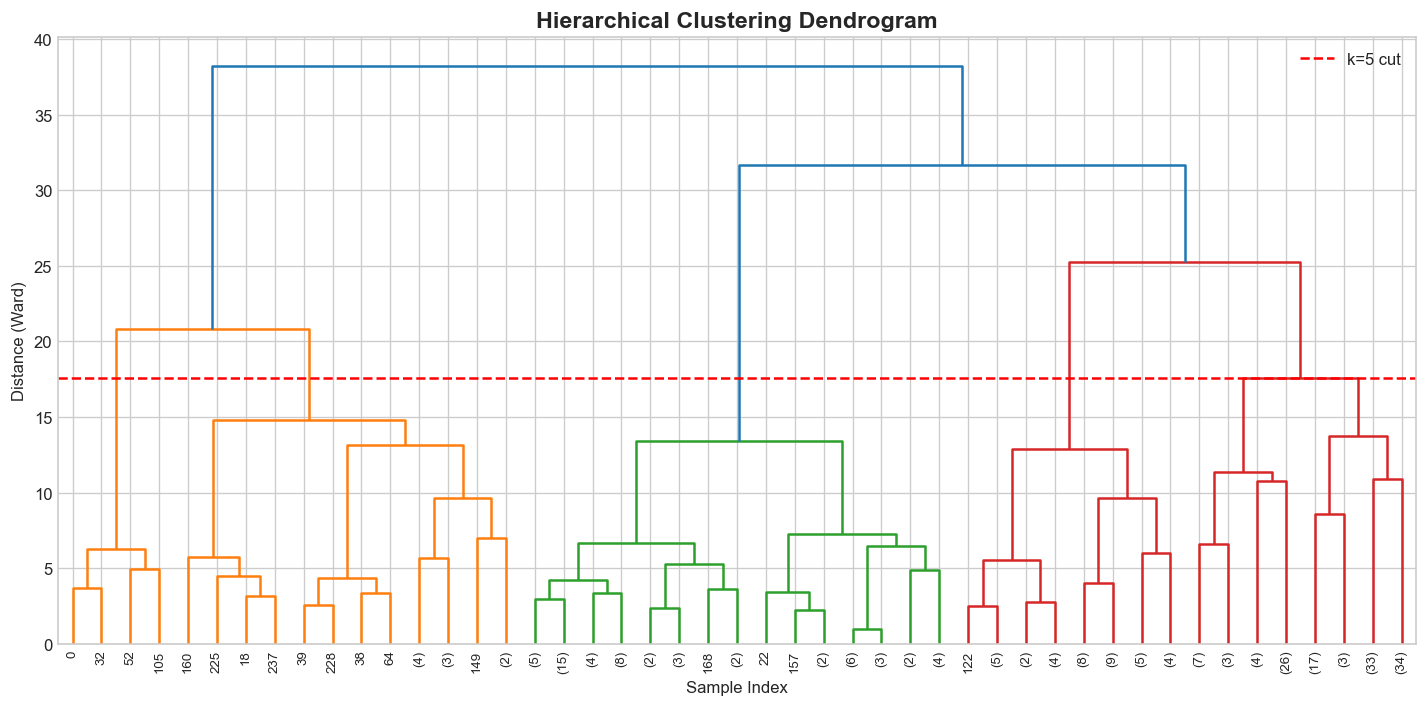

In [8]:
# Create dendrogram
fig, ax = plt.subplots(figsize=(12, 6))

linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=5,
           leaf_font_size=8, color_threshold=0.7*max(linkage_matrix[:,2]))

ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance (Ward)')
ax.set_title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
ax.axhline(y=linkage_matrix[-5, 2], color='r', linestyle='--', label='k=5 cut')
ax.legend()

plt.tight_layout()
plt.savefig('../output/figures/hierarchical_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Final Clustering Selection

Based on the clustering comparison above, we select **K-Means (k=4)** because:
- Best Silhouette score among methods meeting validity criteria
- All clusters have sufficient size (>= 10 patients)
- Stable and reproducible results
- Clinically interpretable number of phenotypes

In [17]:
# Final clustering selection
SELECTED_METHOD = 'K-Means (k=4)'
N_CLUSTERS = 4

labels = clustering_results[SELECTED_METHOD]
features_df['phenotype'] = labels

# Define phenotype names (will be refined after characterization)
PHENOTYPE_NAMES = {i: f'P{i}' for i in range(N_CLUSTERS)}

# Cluster sizes
print("=" * 50)
print(f"SELECTED: {SELECTED_METHOD}")
print("=" * 50)
print("\nCLUSTER SIZES:")
for p in range(N_CLUSTERS):
    n = (labels == p).sum()
    pct = 100 * n / len(labels)
    print(f"  {PHENOTYPE_NAMES[p]}: {n} patients ({pct:.1f}%)")

SELECTED: K-Means (k=4)

CLUSTER SIZES:
  P0: 22 patients (8.9%)
  P1: 76 patients (30.9%)
  P2: 88 patients (35.8%)
  P3: 60 patients (24.4%)


C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


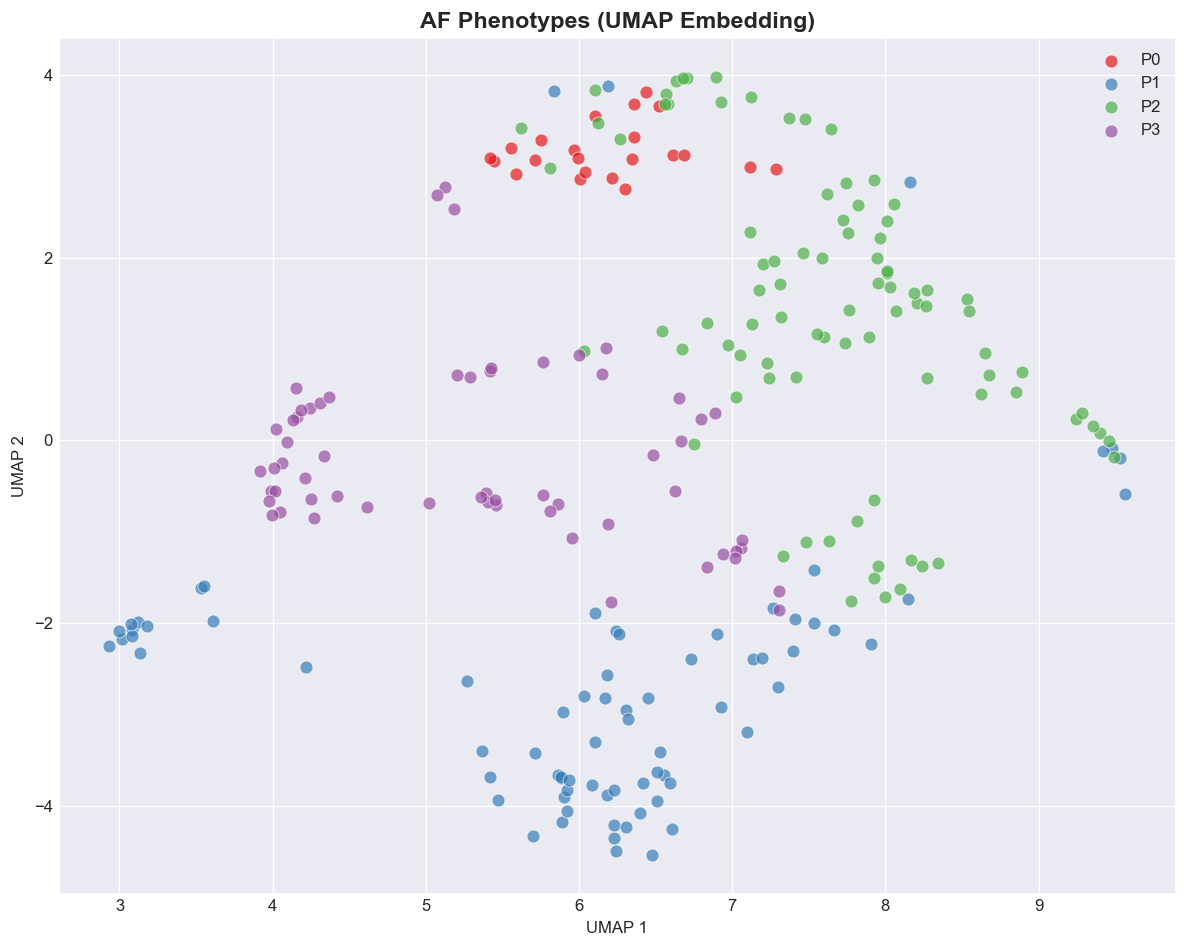

In [18]:
# UMAP for cluster visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = reducer.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
for p in range(N_CLUSTERS):
    mask = labels == p
    ax.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1],
               c=PHENOTYPE_COLORS[p], label=PHENOTYPE_NAMES[p],
               alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('AF Phenotypes (UMAP Embedding)', fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
plt.tight_layout()
plt.savefig('../output/figures/umap_phenotypes.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 4. Phenotype Characterization

In [19]:
# Key characterization features
char_features = {
    'Burden': ['total_af_hours', 'af_burden_percent', 'n_episodes'],
    'Episode Pattern': ['mean_episode_duration', 'cv_episode_duration', 'burstiness_index'],
    'Temporal': ['pct_daytime_episodes', 'hourly_entropy'],
    'Heart Rate': ['mean_ventricular_rate', 'pct_rapid_af', 'pct_controlled_af'],
    'Trajectory': ['trajectory_slope']
}

# Create profile table
profiles = []
for p in range(N_CLUSTERS):
    subset = features_df[features_df['phenotype'] == p]
    profile = {'Phenotype': PHENOTYPE_NAMES[p], 'N': len(subset)}
    
    for domain, feats in char_features.items():
        for feat in feats:
            if feat in subset.columns:
                profile[feat] = subset[feat].mean()
    
    profiles.append(profile)

profile_df = pd.DataFrame(profiles)
print("\nPHENOTYPE PROFILES")
print("=" * 80)
display(profile_df.round(1))


PHENOTYPE PROFILES


,Phenotype,N,total_af_hours,af_burden_percent,n_episodes,mean_episode_duration,cv_episode_duration,burstiness_index,pct_daytime_episodes,hourly_entropy,mean_ventricular_rate,pct_rapid_af,pct_controlled_af,trajectory_slope
0,P0,22,3684.6,47.4,1140.1,6572.5,4.4,0.4,66.9,3.8,85.2,15.9,72.7,798.2
1,P1,76,149.9,2.2,133.0,175.0,1.3,0.2,89.2,2.8,128.6,83.2,16.7,62.5
2,P2,88,530.6,6.7,458.0,229.6,2.2,0.4,75.4,4.1,86.9,17.6,75.9,120.9
3,P3,60,35.5,0.8,6.4,706.2,0.5,-0.2,68.1,1.6,88.2,11.1,87.3,75.7


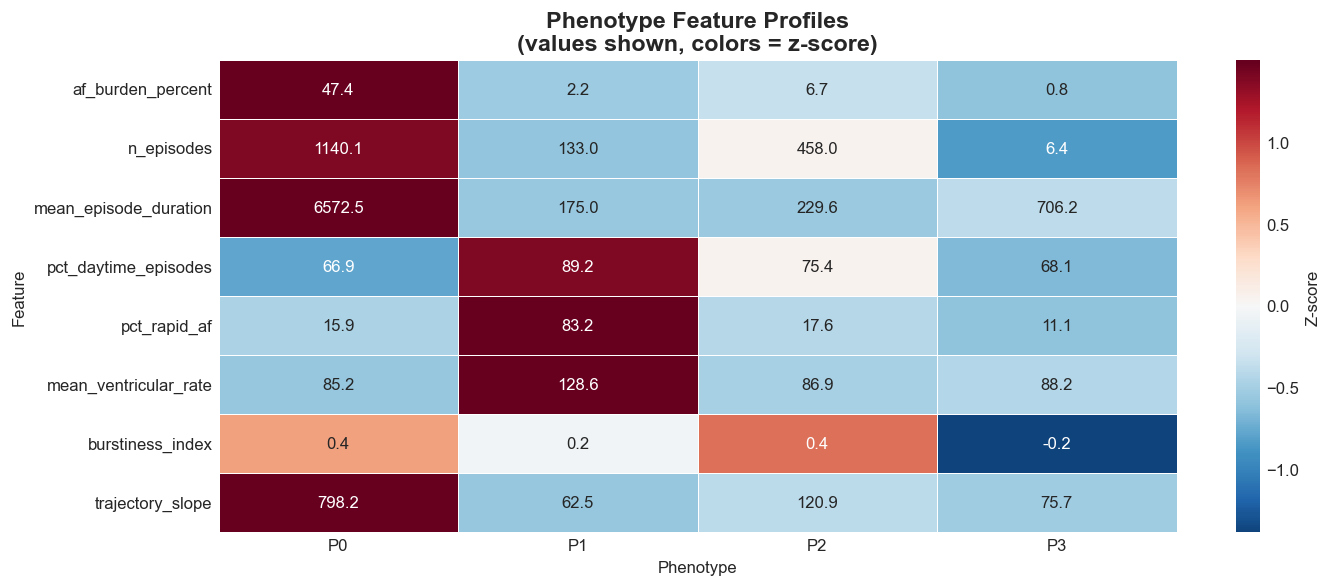

In [20]:
# Feature heatmap
heatmap_features = ['af_burden_percent', 'n_episodes', 'mean_episode_duration',
                    'pct_daytime_episodes', 'pct_rapid_af', 'mean_ventricular_rate',
                    'burstiness_index', 'trajectory_slope']
available_heatmap = [f for f in heatmap_features if f in features_df.columns]

# Calculate means per phenotype
heatmap_data = features_df.groupby('phenotype')[available_heatmap].mean()

# Z-score for visualization
heatmap_z = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(heatmap_z.T, cmap='RdBu_r', center=0, annot=heatmap_data.T.round(1),
            fmt='', linewidths=0.5, ax=ax, cbar_kws={'label': 'Z-score'},
            xticklabels=[f'P{i}' for i in range(N_CLUSTERS)])
ax.set_title('Phenotype Feature Profiles\n(values shown, colors = z-score)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Phenotype')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('../output/figures/feature_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

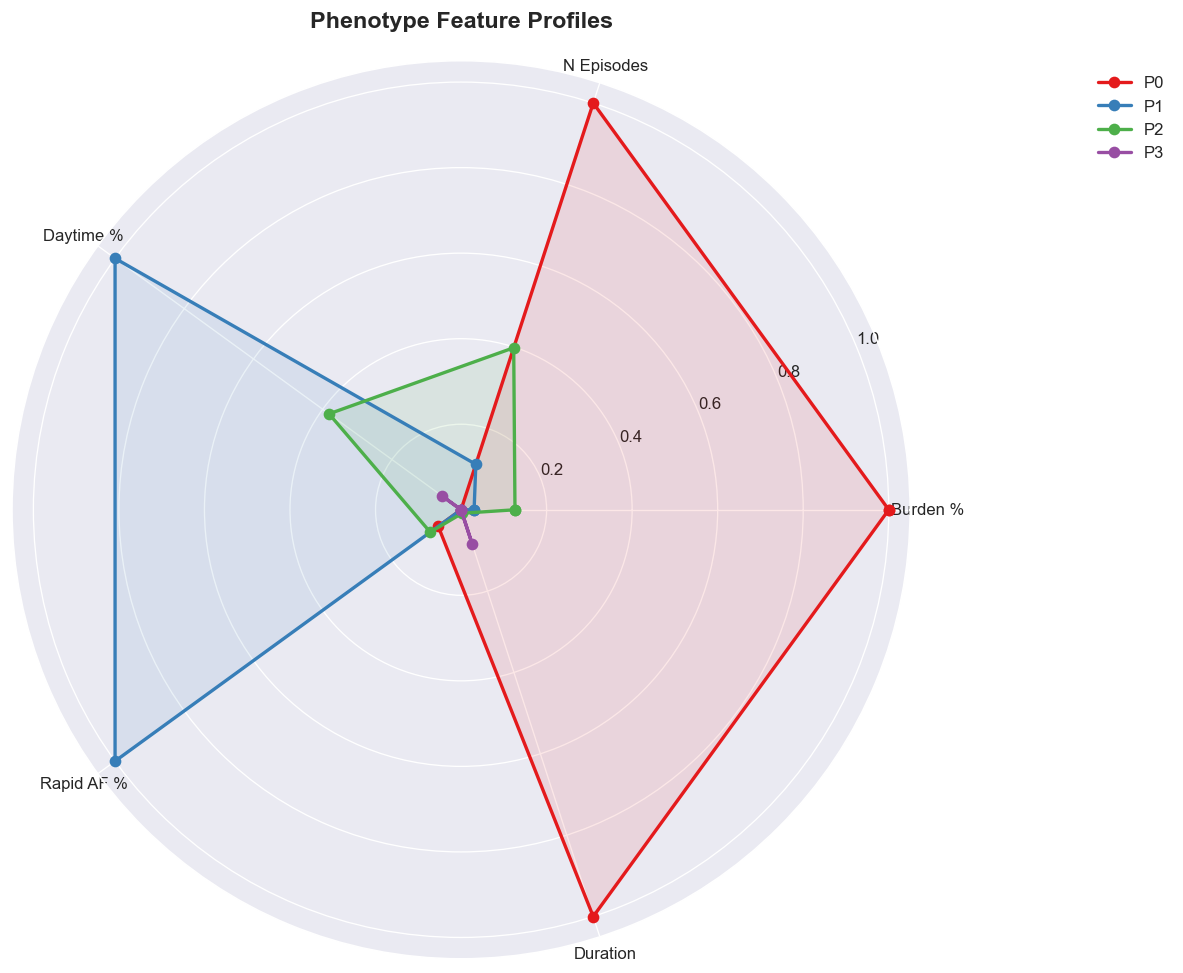

In [21]:
# Radar chart
radar_features = ['af_burden_percent', 'n_episodes', 'pct_daytime_episodes',
                  'pct_rapid_af', 'mean_episode_duration']
available_radar = [f for f in radar_features if f in features_df.columns]

# Normalize to 0-1
radar_data = features_df.groupby('phenotype')[available_radar].mean()
radar_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Radar plot
angles = np.linspace(0, 2*np.pi, len(available_radar), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for p in range(N_CLUSTERS):
    values = radar_normalized.iloc[p].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', color=PHENOTYPE_COLORS[p],
            label=PHENOTYPE_NAMES[p], linewidth=2)
    ax.fill(angles, values, color=PHENOTYPE_COLORS[p], alpha=0.1)

ax.set_xticks(angles[:-1])
feature_labels = ['Burden %', 'N Episodes', 'Daytime %', 'Rapid AF %', 'Duration']
ax.set_xticklabels(feature_labels)
ax.set_title('Phenotype Feature Profiles', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('../output/figures/radar_phenotypes.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Clinical interpretation - based on profile data above
print("=" * 70)
print("PHENOTYPE SUMMARY")
print("=" * 70)

for p in range(N_CLUSTERS):
    subset = features_df[features_df['phenotype'] == p]
    n = len(subset)
    pct = 100 * n / len(features_df)
    
    # Key metrics
    burden = subset['af_burden_percent'].mean()
    n_eps = subset['n_episodes'].mean()
    duration = subset['mean_episode_duration'].mean()
    rapid = subset['pct_rapid_af'].mean()
    daytime = subset['pct_daytime_episodes'].mean()
    
    print(f"\n{PHENOTYPE_NAMES[p]}: N = {n} patients ({pct:.0f}%)")
    print("-" * 50)
    print(f"   AF Burden: {burden:.1f}%")
    print(f"   Episodes: {n_eps:.0f} (mean duration: {duration:.0f} min)")
    print(f"   Rapid AF: {rapid:.0f}%")
    print(f"   Daytime episodes: {daytime:.0f}%")
    
print("\n" + "=" * 70)
print("Note: Phenotype names should be refined based on")
print("the clinical characteristics above after reviewing the data.")
print("=" * 70)

PHENOTYPE SUMMARY

P0: N = 22 patients (9%)
--------------------------------------------------
   AF Burden: 47.4%
   Episodes: 1140 (mean duration: 6573 min)
   Rapid AF: 16%
   Daytime episodes: 67%

P1: N = 76 patients (31%)
--------------------------------------------------
   AF Burden: 2.2%
   Episodes: 133 (mean duration: 175 min)
   Rapid AF: 83%
   Daytime episodes: 89%

P2: N = 88 patients (36%)
--------------------------------------------------
   AF Burden: 6.7%
   Episodes: 458 (mean duration: 230 min)
   Rapid AF: 18%
   Daytime episodes: 75%

P3: N = 60 patients (24%)
--------------------------------------------------
   AF Burden: 0.8%
   Episodes: 6 (mean duration: 706 min)
   Rapid AF: 11%
   Daytime episodes: 68%

Note: Phenotype names (P0, P1, P2) should be refined based on
the clinical characteristics above after reviewing the data.


---
## 5. Feature Importance Analysis

In [23]:
# Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, labels)

# Get feature importances
rf_importance = pd.DataFrame({
    'feature': valid_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# ANOVA F-scores
f_scores, p_values = f_classif(X_scaled, labels)
anova_importance = pd.DataFrame({
    'feature': valid_features,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print("=" * 60)
print("TOP 15 FEATURES - RANDOM FOREST IMPORTANCE")
print("=" * 60)
print(rf_importance.head(15).to_string(index=False))

print("\n" + "=" * 60)
print("TOP 15 FEATURES - ANOVA F-SCORE")
print("=" * 60)
print(anova_importance.head(15).to_string(index=False))

TOP 15 FEATURES - RANDOM FOREST IMPORTANCE
                 feature  importance
   mean_ventricular_rate    0.145105
            pct_rapid_af    0.140969
       pct_controlled_af    0.124339
              n_episodes    0.098095
       af_burden_percent    0.083042
          hourly_entropy    0.080769
          total_af_hours    0.065841
longest_plateau_episodes    0.058602
        trajectory_slope    0.052761
        burstiness_index    0.046863
     cv_episode_duration    0.044843
    max_episode_duration    0.027081
    pct_daytime_episodes    0.016356
   mean_episode_duration    0.015333

TOP 15 FEATURES - ANOVA F-SCORE
                 feature    f_score      p_value
       af_burden_percent 278.006878 4.283023e-78
            pct_rapid_af 236.819574 1.079978e-71
          total_af_hours 226.903473 4.994739e-70
       pct_controlled_af 212.100913 1.934558e-67
   mean_ventricular_rate 138.843530 2.458810e-52
        trajectory_slope  91.280995 1.535624e-39
    max_episode_duration  

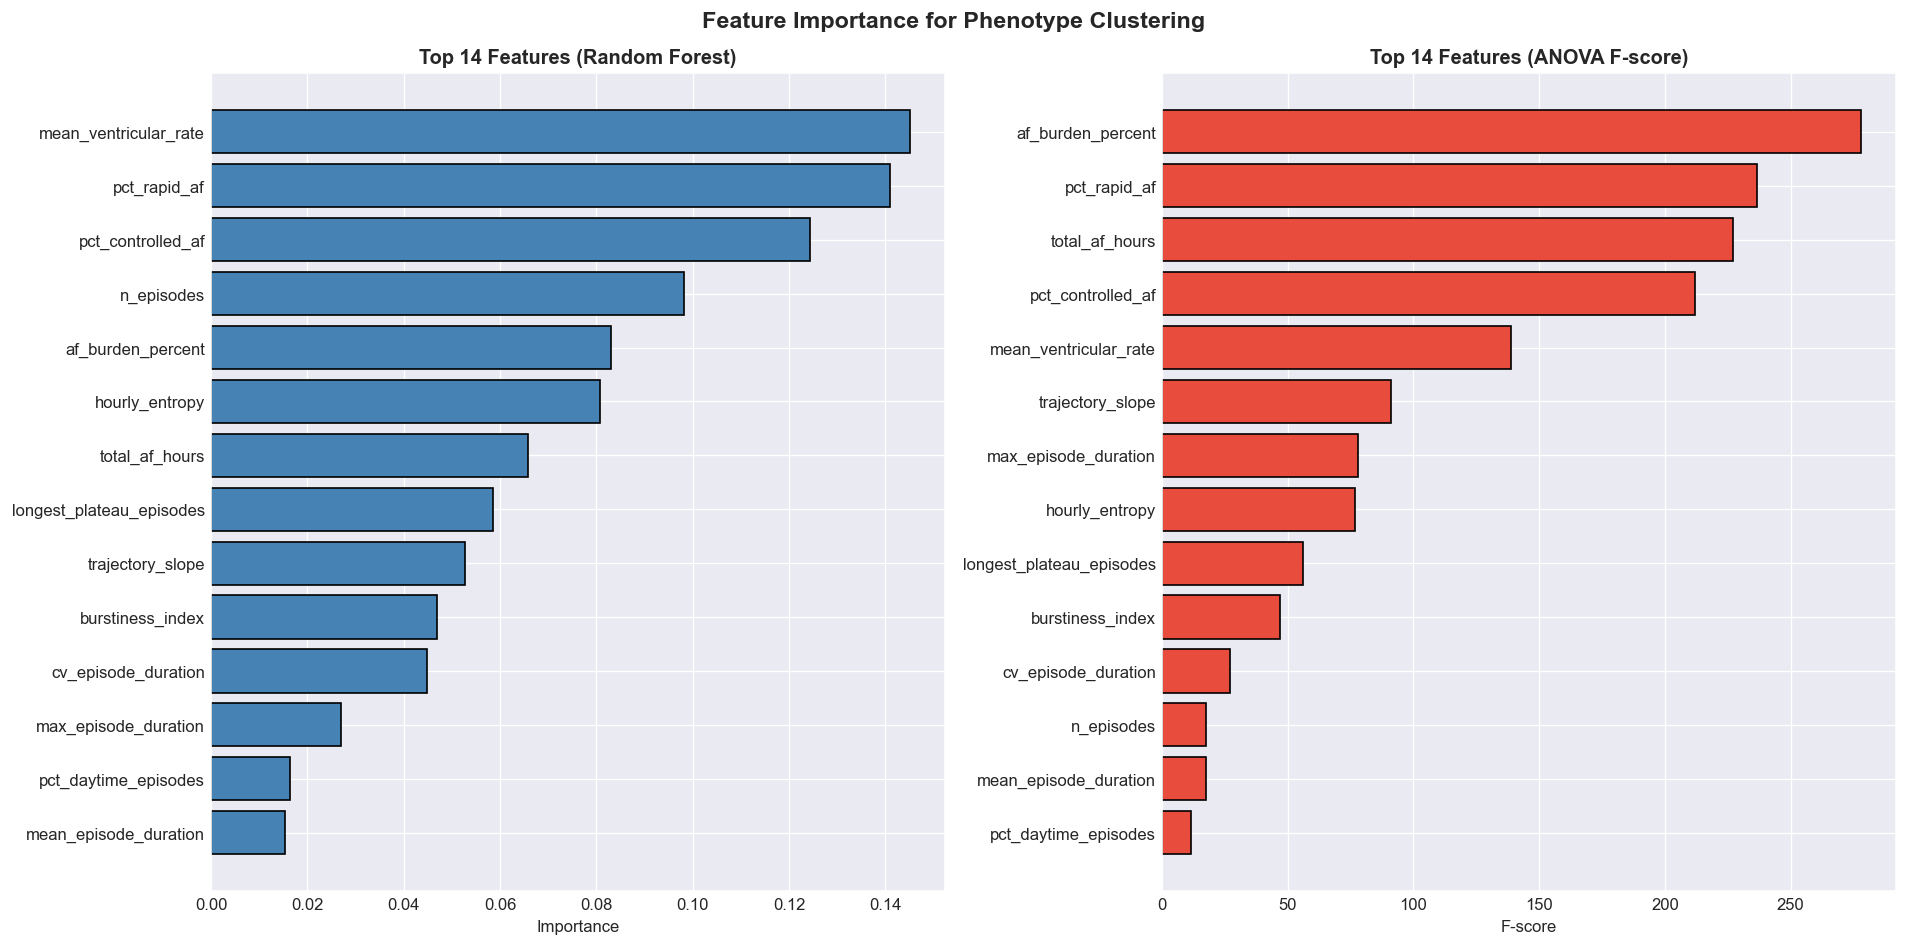

In [25]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Adjust top_n to not exceed available features
top_n = min(20, len(rf_importance))

# Random Forest importance
top_rf = rf_importance.head(top_n).iloc[::-1]  # Reverse for horizontal bar
axes[0].barh(range(len(top_rf)), top_rf['importance'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {len(top_rf)} Features (Random Forest)', fontweight='bold')

# ANOVA F-score
top_anova = anova_importance.head(top_n).iloc[::-1]
axes[1].barh(range(len(top_anova)), top_anova['f_score'], color='#e74c3c', edgecolor='black')
axes[1].set_yticks(range(len(top_anova)))
axes[1].set_yticklabels(top_anova['feature'])
axes[1].set_xlabel('F-score')
axes[1].set_title(f'Top {len(top_anova)} Features (ANOVA F-score)', fontweight='bold')

plt.suptitle('Feature Importance for Phenotype Clustering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Trajectory Visualization

Visualize how AF phenotypes evolve over the 365-day ILR monitoring period.

In [26]:
# Load episodes with time alignment
loader = AFDataLoader()
df_episodes = loader.load_episodes()

# Clean episodes
cleaner = EpisodeCleaner()
df_clean, cleaning_report = cleaner.clean(df_episodes)

# Align to 365-day window
aligner = TimeAligner()
df_aligned = aligner.align(df_clean)

# Fix ID types for merging
df_aligned['ID'] = df_aligned['ID'].astype(str).str.replace('.0', '', regex=False)
features_df['ID'] = features_df['ID'].astype(str).str.replace('.0', '', regex=False)

# Merge phenotype labels with episodes
df_aligned = df_aligned.merge(features_df[['ID', 'phenotype']], on='ID', how='inner')

print(f"Episodes with phenotype labels: {len(df_aligned):,}")
print(f"Patients: {df_aligned['ID'].nunique()}")

Removed 21 episodes with zero duration
Removed 112 episodes with duration > 10080 minutes
Removed 1 episodes with invalid RR interval

Final: 170,047 episodes (99.9% retained)
Excluded 2330 episodes occurring before implant
Excluded 50993 episodes beyond 365 days follow-up
Aligned 116,724 episodes (68.6% of original)
Episodes with phenotype labels: 109,982
Patients: 245


In [27]:
# Time grid for trajectories (0-365 days)
TIME_GRID = np.arange(0, 366)

def get_cumulative_burden_trajectory(patient_episodes, time_grid=TIME_GRID):
    """Calculate cumulative AF burden (minutes) at each day for a single patient."""
    if len(patient_episodes) == 0:
        return np.zeros(len(time_grid))
    
    eps = patient_episodes.sort_values('days_since_implant').copy()
    trajectory = np.zeros(len(time_grid))
    for i, day in enumerate(time_grid):
        mask = eps['days_since_implant'] <= day
        trajectory[i] = eps.loc[mask, 'af_episode_minutes'].sum() if mask.any() else 0
    return trajectory

def calc_mean_ci(trajectories):
    """Calculate mean and 95% CI from list of trajectories."""
    arr = np.array(trajectories)
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    n = len(arr)
    ci = 1.96 * std / np.sqrt(n)
    return mean, ci, std

# Calculate trajectories for each phenotype
burden_trajectories = {p: [] for p in range(N_CLUSTERS)}

for _, row in features_df[['ID', 'phenotype']].drop_duplicates().iterrows():
    patient_id = row['ID']
    phenotype = row['phenotype']
    patient_eps = df_aligned[df_aligned['ID'] == patient_id]
    burden_traj = get_cumulative_burden_trajectory(patient_eps)
    burden_trajectories[phenotype].append(burden_traj)

print("Trajectories calculated for all patients")

Trajectories calculated for all patients


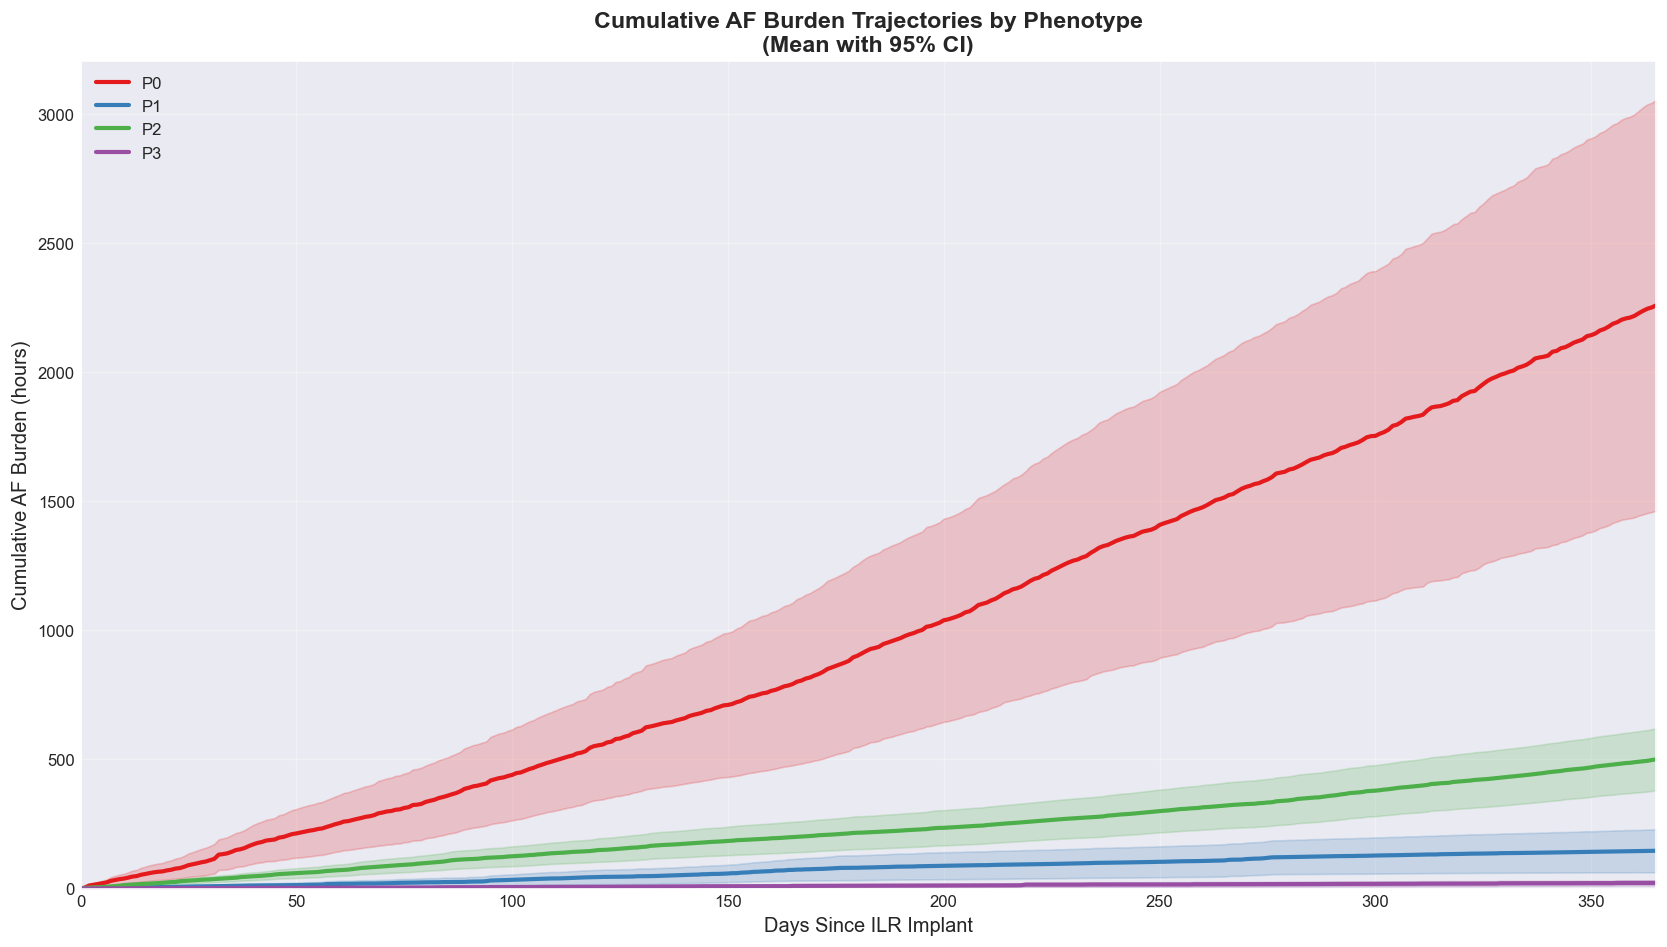

In [28]:
# Plot cumulative burden trajectories
fig, ax = plt.subplots(figsize=(14, 8))

for p in range(N_CLUSTERS):
    mean, ci, std = calc_mean_ci(burden_trajectories[p])
    mean_hours = mean / 60
    ci_hours = ci / 60
    
    ax.plot(TIME_GRID, mean_hours, color=PHENOTYPE_COLORS[p], 
            label=PHENOTYPE_NAMES[p], lw=2.5)
    ax.fill_between(TIME_GRID, mean_hours - ci_hours, mean_hours + ci_hours,
                    color=PHENOTYPE_COLORS[p], alpha=0.2)

ax.set_xlabel('Days Since ILR Implant', fontsize=12)
ax.set_ylabel('Cumulative AF Burden (hours)', fontsize=12)
ax.set_title('Cumulative AF Burden Trajectories by Phenotype\n(Mean with 95% CI)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0, 365)
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/trajectory_cumulative_burden.png', dpi=150, bbox_inches='tight')
plt.show()

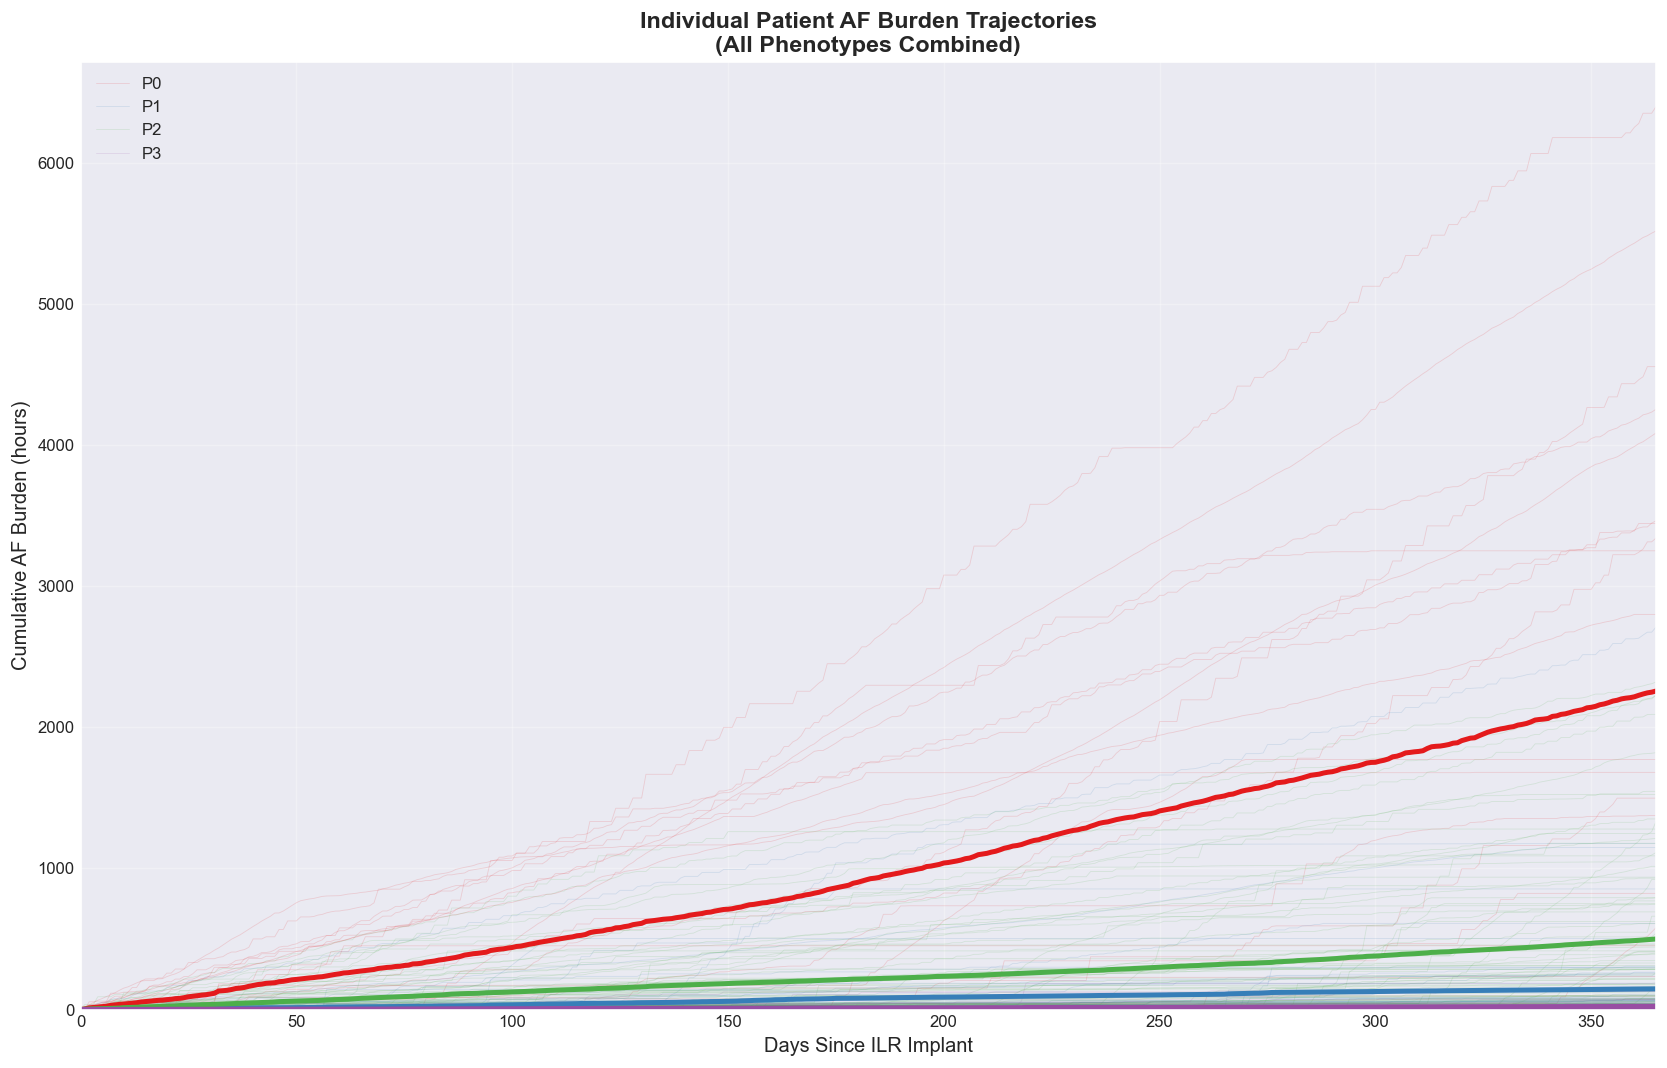

In [29]:
# Combined spaghetti plot - all phenotypes on one plot
fig, ax = plt.subplots(figsize=(14, 9))

# Plot individual trajectories
for p in range(N_CLUSTERS):
    for i, traj in enumerate(burden_trajectories[p]):
        label = PHENOTYPE_NAMES[p] if i == 0 else None
        ax.plot(TIME_GRID, traj / 60, color=PHENOTYPE_COLORS[p], 
                alpha=0.15, lw=0.5, label=label)

# Plot mean trajectories on top
for p in range(N_CLUSTERS):
    mean, ci, _ = calc_mean_ci(burden_trajectories[p])
    ax.plot(TIME_GRID, mean / 60, color=PHENOTYPE_COLORS[p], lw=3, linestyle='-')

ax.set_xlabel('Days Since ILR Implant', fontsize=12)
ax.set_ylabel('Cumulative AF Burden (hours)', fontsize=12)
ax.set_title('Individual Patient AF Burden Trajectories\n(All Phenotypes Combined)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 365)
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('../output/figures/trajectory_spaghetti_combined.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Summary Dashboard

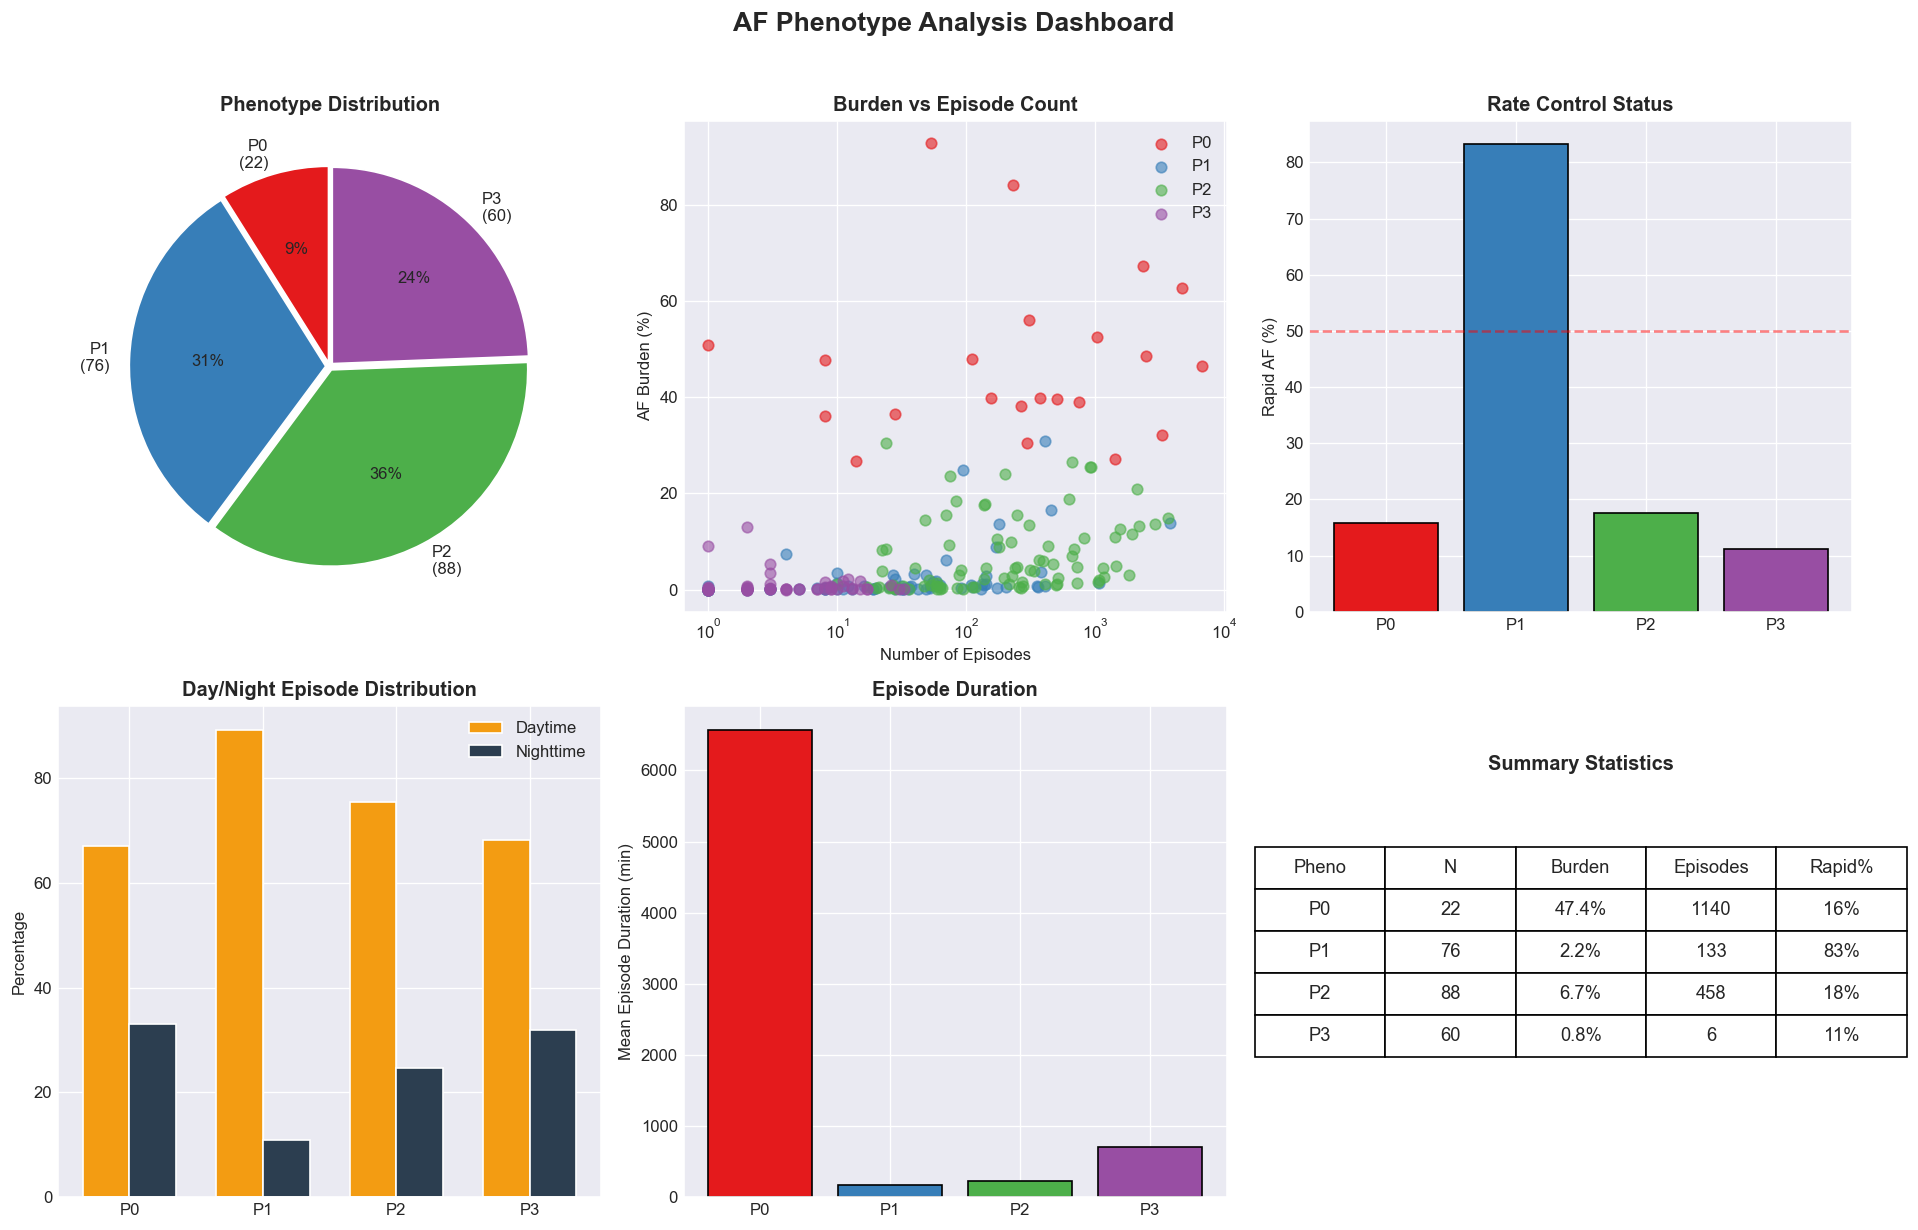

In [30]:
# Summary dashboard
fig = plt.figure(figsize=(16, 10))

# Phenotype sizes (pie chart)
ax1 = fig.add_subplot(2, 3, 1)
sizes = [len(features_df[features_df['phenotype'] == p]) for p in range(N_CLUSTERS)]
labels_pie = [f'P{p}\n({s})' for p, s in enumerate(sizes)]
ax1.pie(sizes, labels=labels_pie, colors=PHENOTYPE_COLORS[:N_CLUSTERS], autopct='%1.0f%%',
        startangle=90, explode=[0.02]*N_CLUSTERS)
ax1.set_title('Phenotype Distribution', fontweight='bold')

# Burden vs Episodes scatter
ax2 = fig.add_subplot(2, 3, 2)
for p in range(N_CLUSTERS):
    mask = features_df['phenotype'] == p
    ax2.scatter(features_df.loc[mask, 'n_episodes'], 
                features_df.loc[mask, 'af_burden_percent'],
                c=PHENOTYPE_COLORS[p], label=f'P{p}', alpha=0.6, s=40)
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('AF Burden (%)')
ax2.set_title('Burden vs Episode Count', fontweight='bold')
ax2.set_xscale('log')
ax2.legend()

# Rapid AF by phenotype
ax3 = fig.add_subplot(2, 3, 3)
rapid_means = [features_df[features_df['phenotype'] == p]['pct_rapid_af'].mean() for p in range(N_CLUSTERS)]
ax3.bar(range(N_CLUSTERS), rapid_means, color=PHENOTYPE_COLORS[:N_CLUSTERS], edgecolor='black')
ax3.set_xticks(range(N_CLUSTERS))
ax3.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax3.set_ylabel('Rapid AF (%)')
ax3.set_title('Rate Control Status', fontweight='bold')
ax3.axhline(50, color='red', linestyle='--', alpha=0.5)

# Day/Night pattern
ax4 = fig.add_subplot(2, 3, 4)
day_means = [features_df[features_df['phenotype'] == p]['pct_daytime_episodes'].mean() for p in range(N_CLUSTERS)]
night_means = [100 - d for d in day_means]
x = np.arange(N_CLUSTERS)
width = 0.35
ax4.bar(x - width/2, day_means, width, label='Daytime', color='#f39c12')
ax4.bar(x + width/2, night_means, width, label='Nighttime', color='#2c3e50')
ax4.set_xticks(x)
ax4.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax4.set_ylabel('Percentage')
ax4.set_title('Day/Night Episode Distribution', fontweight='bold')
ax4.legend()

# Episode duration
ax5 = fig.add_subplot(2, 3, 5)
dur_means = [features_df[features_df['phenotype'] == p]['mean_episode_duration'].mean() for p in range(N_CLUSTERS)]
ax5.bar(range(N_CLUSTERS), dur_means, color=PHENOTYPE_COLORS[:N_CLUSTERS], edgecolor='black')
ax5.set_xticks(range(N_CLUSTERS))
ax5.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax5.set_ylabel('Mean Episode Duration (min)')
ax5.set_title('Episode Duration', fontweight='bold')

# Summary table
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
table_data = []
for p in range(N_CLUSTERS):
    subset = features_df[features_df['phenotype'] == p]
    burden = subset['af_burden_percent'].mean()
    n_ep = subset['n_episodes'].mean()
    rapid = subset['pct_rapid_af'].mean()
    table_data.append([f'P{p}', f'{len(subset)}', f'{burden:.1f}%', 
                       f'{n_ep:.0f}', f'{rapid:.0f}%'])

table = ax6.table(cellText=table_data,
                  colLabels=['Pheno', 'N', 'Burden', 'Episodes', 'Rapid%'],
                  loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax6.set_title('Summary Statistics', fontweight='bold', y=0.85)

plt.suptitle('AF Phenotype Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../output/figures/phenotype_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary dashboard
fig = plt.figure(figsize=(16, 10))

# Phenotype sizes (pie chart)
ax1 = fig.add_subplot(2, 3, 1)
sizes = [len(features_df[features_df['phenotype'] == p]) for p in range(N_CLUSTERS)]
labels_pie = [f'P{p}\n({s})' for p, s in enumerate(sizes)]
ax1.pie(sizes, labels=labels_pie, colors=PHENOTYPE_COLORS[:N_CLUSTERS], autopct='%1.0f%%',
        startangle=90, explode=[0.02]*N_CLUSTERS)
ax1.set_title('Phenotype Distribution', fontweight='bold')

# Burden vs Episodes scatter
ax2 = fig.add_subplot(2, 3, 2)
for p in range(N_CLUSTERS):
    mask = features_df['phenotype'] == p
    ax2.scatter(features_df.loc[mask, 'n_episodes'], 
                features_df.loc[mask, 'af_burden_percent'],
                c=PHENOTYPE_COLORS[p], label=f'P{p}', alpha=0.6, s=40)
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('AF Burden (%)')
ax2.set_title('Burden vs Episode Count', fontweight='bold')
ax2.set_xscale('log')
ax2.legend()

# Rapid AF by phenotype
ax3 = fig.add_subplot(2, 3, 3)
rapid_means = [features_df[features_df['phenotype'] == p]['pct_rapid_af'].mean() for p in range(N_CLUSTERS)]
ax3.bar(range(N_CLUSTERS), rapid_means, color=PHENOTYPE_COLORS[:N_CLUSTERS], edgecolor='black')
ax3.set_xticks(range(N_CLUSTERS))
ax3.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax3.set_ylabel('Rapid AF (%)')
ax3.set_title('Rate Control Status', fontweight='bold')
ax3.axhline(50, color='red', linestyle='--', alpha=0.5)

# Day/Night pattern
ax4 = fig.add_subplot(2, 3, 4)
day_means = [features_df[features_df['phenotype'] == p]['pct_daytime_episodes'].mean() for p in range(N_CLUSTERS)]
night_means = [100 - d for d in day_means]
x = np.arange(N_CLUSTERS)
width = 0.35
ax4.bar(x - width/2, day_means, width, label='Daytime', color='#f39c12')
ax4.bar(x + width/2, night_means, width, label='Nighttime', color='#2c3e50')
ax4.set_xticks(x)
ax4.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax4.set_ylabel('Percentage')
ax4.set_title('Day/Night Episode Distribution', fontweight='bold')
ax4.legend()

# Episode duration
ax5 = fig.add_subplot(2, 3, 5)
dur_means = [features_df[features_df['phenotype'] == p]['mean_episode_duration'].mean() for p in range(N_CLUSTERS)]
ax5.bar(range(N_CLUSTERS), dur_means, color=PHENOTYPE_COLORS[:N_CLUSTERS], edgecolor='black')
ax5.set_xticks(range(N_CLUSTERS))
ax5.set_xticklabels([f'P{i}' for i in range(N_CLUSTERS)])
ax5.set_ylabel('Mean Episode Duration (min)')
ax5.set_title('Episode Duration', fontweight='bold')

# Summary table
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
table_data = []
for p in range(N_CLUSTERS):
    subset = features_df[features_df['phenotype'] == p]
    burden = subset['af_burden_percent'].mean()
    n_ep = subset['n_episodes'].mean()
    duration = subset['mean_episode_duration'].mean()
    rapid = subset['pct_rapid_af'].mean()
    daytime = subset['pct_daytime_episodes'].mean()
    table_data.append([f'P{p}', f'{len(subset)}', f'{burden:.1f}%', 
                       f'{n_ep:.0f}', f'{duration:.0f}', f'{rapid:.0f}%', f'{daytime:.0f}%'])

table = ax6.table(cellText=table_data,
                  colLabels=['Pheno', 'N', 'Burden', 'Episodes', 'Duration', 'Rapid%', 'Day%'],
                  loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)
ax6.set_title('Summary Statistics', fontweight='bold', y=0.85)

plt.suptitle('AF Phenotype Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../output/figures/phenotype_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

In [31]:
# Save phenotype assignments
features_df[['ID', 'phenotype']].to_csv(f'../output/phenotype_assignments_{N_CLUSTERS}k.csv', index=False)
features_df.to_csv(f'../output/features_with_phenotypes_{N_CLUSTERS}k.csv', index=False)

# Save clustering comparison
metrics_df.to_csv('../output/clustering_metrics.csv', index=False)

print("Saved:")
print(f"  - output/phenotype_assignments_{N_CLUSTERS}k.csv")
print(f"  - output/features_with_phenotypes_{N_CLUSTERS}k.csv")
print("  - output/clustering_metrics.csv")
print("  - output/figures/*.png (all visualizations)")

Saved:
  - output/phenotype_assignments_4k.csv
  - output/features_with_phenotypes_4k.csv
  - output/clustering_metrics.csv
  - output/figures/*.png (all visualizations)
